In [2]:
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import diamond as Aztec # the (rather complicated) data structure

In [5]:
import tiling # this contains the algorithm(s) i.e. for tiling and the height function 

In [6]:
def Z(x,y) :
    return (2 / math.pi) * ( (x - 1/2) * math.atan( (math.sqrt(1/4 - (x-1/2)**2 - (y - 1/2)**2)) / (1/2 - y) )
                           + (1/2)* math.atan( (2*(x - 1/2)*(1/2 - y)) / (math.sqrt(1/4 - (x - 1/2)**2 - (y - 1/2)**2)) ) 
                           - (1/2 - y)* math.atan( (x - 1/2) / math.sqrt(1/4 - (x - 1/2)**2 - (y - 1/2)**2 ) ) )

In [7]:
def f_star(y, x) :
    if (y >= 0 and y < 1 / 2) :
        if(x >= 0 and x <= (1 - 2*math.sqrt(y*(1-y))) / 2) :
            return 0
        elif (x > ((1 - 2*math.sqrt(y*(1-y))) / 2 ) and x < ((1 + 2*math.sqrt(y*(1-y))) / 2 )) :
            return ((y/2) + (1/2)*(Z(x,y)))
        elif (x >= ((1 + 2*math.sqrt(y*(1-y))) / 2 )) and (x <= 1) :
            return y
    elif (y == 1/2) :
        return x / 2
    elif (y > 1/2 ) :
        return x - f_star(1 - y, x)
    
def G(x,y) :
    return ( x + y - 2*f_star(y,x) )

@np.vectorize
def R(u, v) : 
    if abs(u) + abs(v) <= 1 :
        return 2*G( (u - v + 1) / 2, (u + v + 1) / 2 )
    else :
        return 0

In [12]:
sizes = [10,20,40,60,80,100,120]
sweeps = 100

In [10]:
# convergence_data = dict()
# for size in sizes :
#     convergence_values = []
#     grid = Aztec.Diamond(size)
#     tiling.weight_computation(grid) # compute Uniform Weights for each tiling
#     for _ in range(sweeps) :
#         M, _ = tiling.generate_matching(grid, energy=False);  # generate a uniform tiling T
#         h = grid.height_function(M)          # compute the associated height function to T i.e. \eta_{T}
        
#         def R(u, v) : 
#             assert (abs(u) + abs(v) <= 1)
#             return 2*G( (u - v + 1) / 2, (u + v + 1) / 2 )
#         term = max([ ( (1/size)*h[(i,j)] - R( i / (size + 1), j / (size + 1) ) ) for (i,j) in list(h.keys())])
#         convergence_values.append(term)
#     convergence_data[size] = convergence_values

In [8]:
# exampleObj = convergence_data

# fileObj = open('convergence_romik.obj', 'wb')
# pickle.dump(exampleObj,fileObj)
# fileObj.close()

In [9]:
fileObj = open('convergence_romik.obj', 'rb')
convergence_data = pickle.load(fileObj)
fileObj.close()

In [25]:
def batch_estimate(data,observable,k):
    '''Divide data into k batches and apply the function observable to each.
    Returns the mean and standard error.'''
    batches = np.reshape(data,(k,-1))
    values = np.apply_along_axis(observable, 1, batches)
    return np.mean(values), np.std(values)/np.sqrt(k-1)

In [26]:
mean_profiles = []
for size in sizes :
    mean_profiles.append(batch_estimate(convergence_data[size],np.mean,20))

Text(0.5, 0, '$N$')

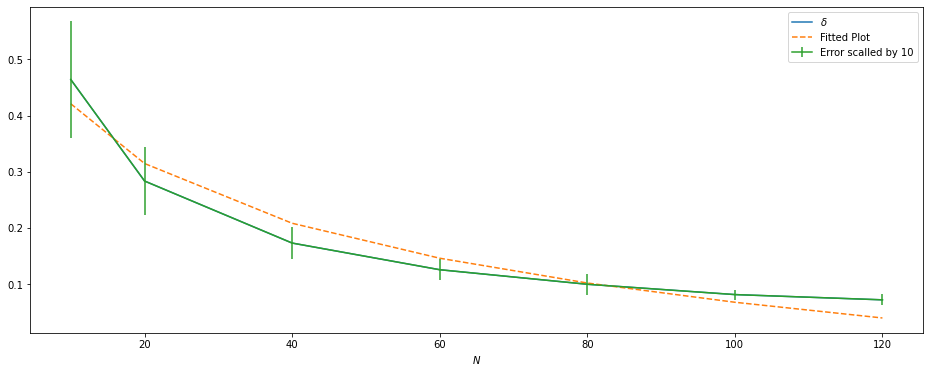

In [57]:
from scipy.optimize import curve_fit

Y, err = list(zip(*mean_profiles))
err = 10 * np.array(err) # Error is too small

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

popt, pcov = curve_fit(func_powerlaw, sizes, Y, maxfev=2000 )

plt.subplots(figsize=(16,6))
plt.plot(sizes, Y, label=r"$\delta$")
plt.plot(sizes, func_powerlaw(sizes, *popt), '--', label="Fitted Plot")
plt.errorbar(sizes, Y, yerr = err, label="Error scalled by 10")
plt.legend()
plt.xlabel(r"$N$")

In [50]:
popt

array([ 1.49469610e-04, -1.02653818e+03,  1.02731256e+03])

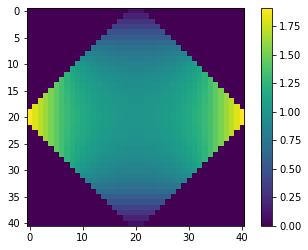

In [66]:
n = 20

A = np.zeros((2*n+1,2*n+1))

for i in range(-n,n+1) :
    for j in range(-n,n+1) :
        A[(i+n,j+n)] = R(i/(n + 1), j/(n + 1))
        
plt.imshow(A, interpolation='nearest')
plt.colorbar()